In [21]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import RandomizedSearchCV

In [22]:
df_test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
df_train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')

## DATA ANALYSIS

#### Quick glance at the training data.

In [23]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [24]:
df_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


#### Numerical features distributions

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'RoomService'}>],
       [<Axes: title={'center': 'FoodCourt'}>,
        <Axes: title={'center': 'ShoppingMall'}>],
       [<Axes: title={'center': 'Spa'}>,
        <Axes: title={'center': 'VRDeck'}>]], dtype=object)

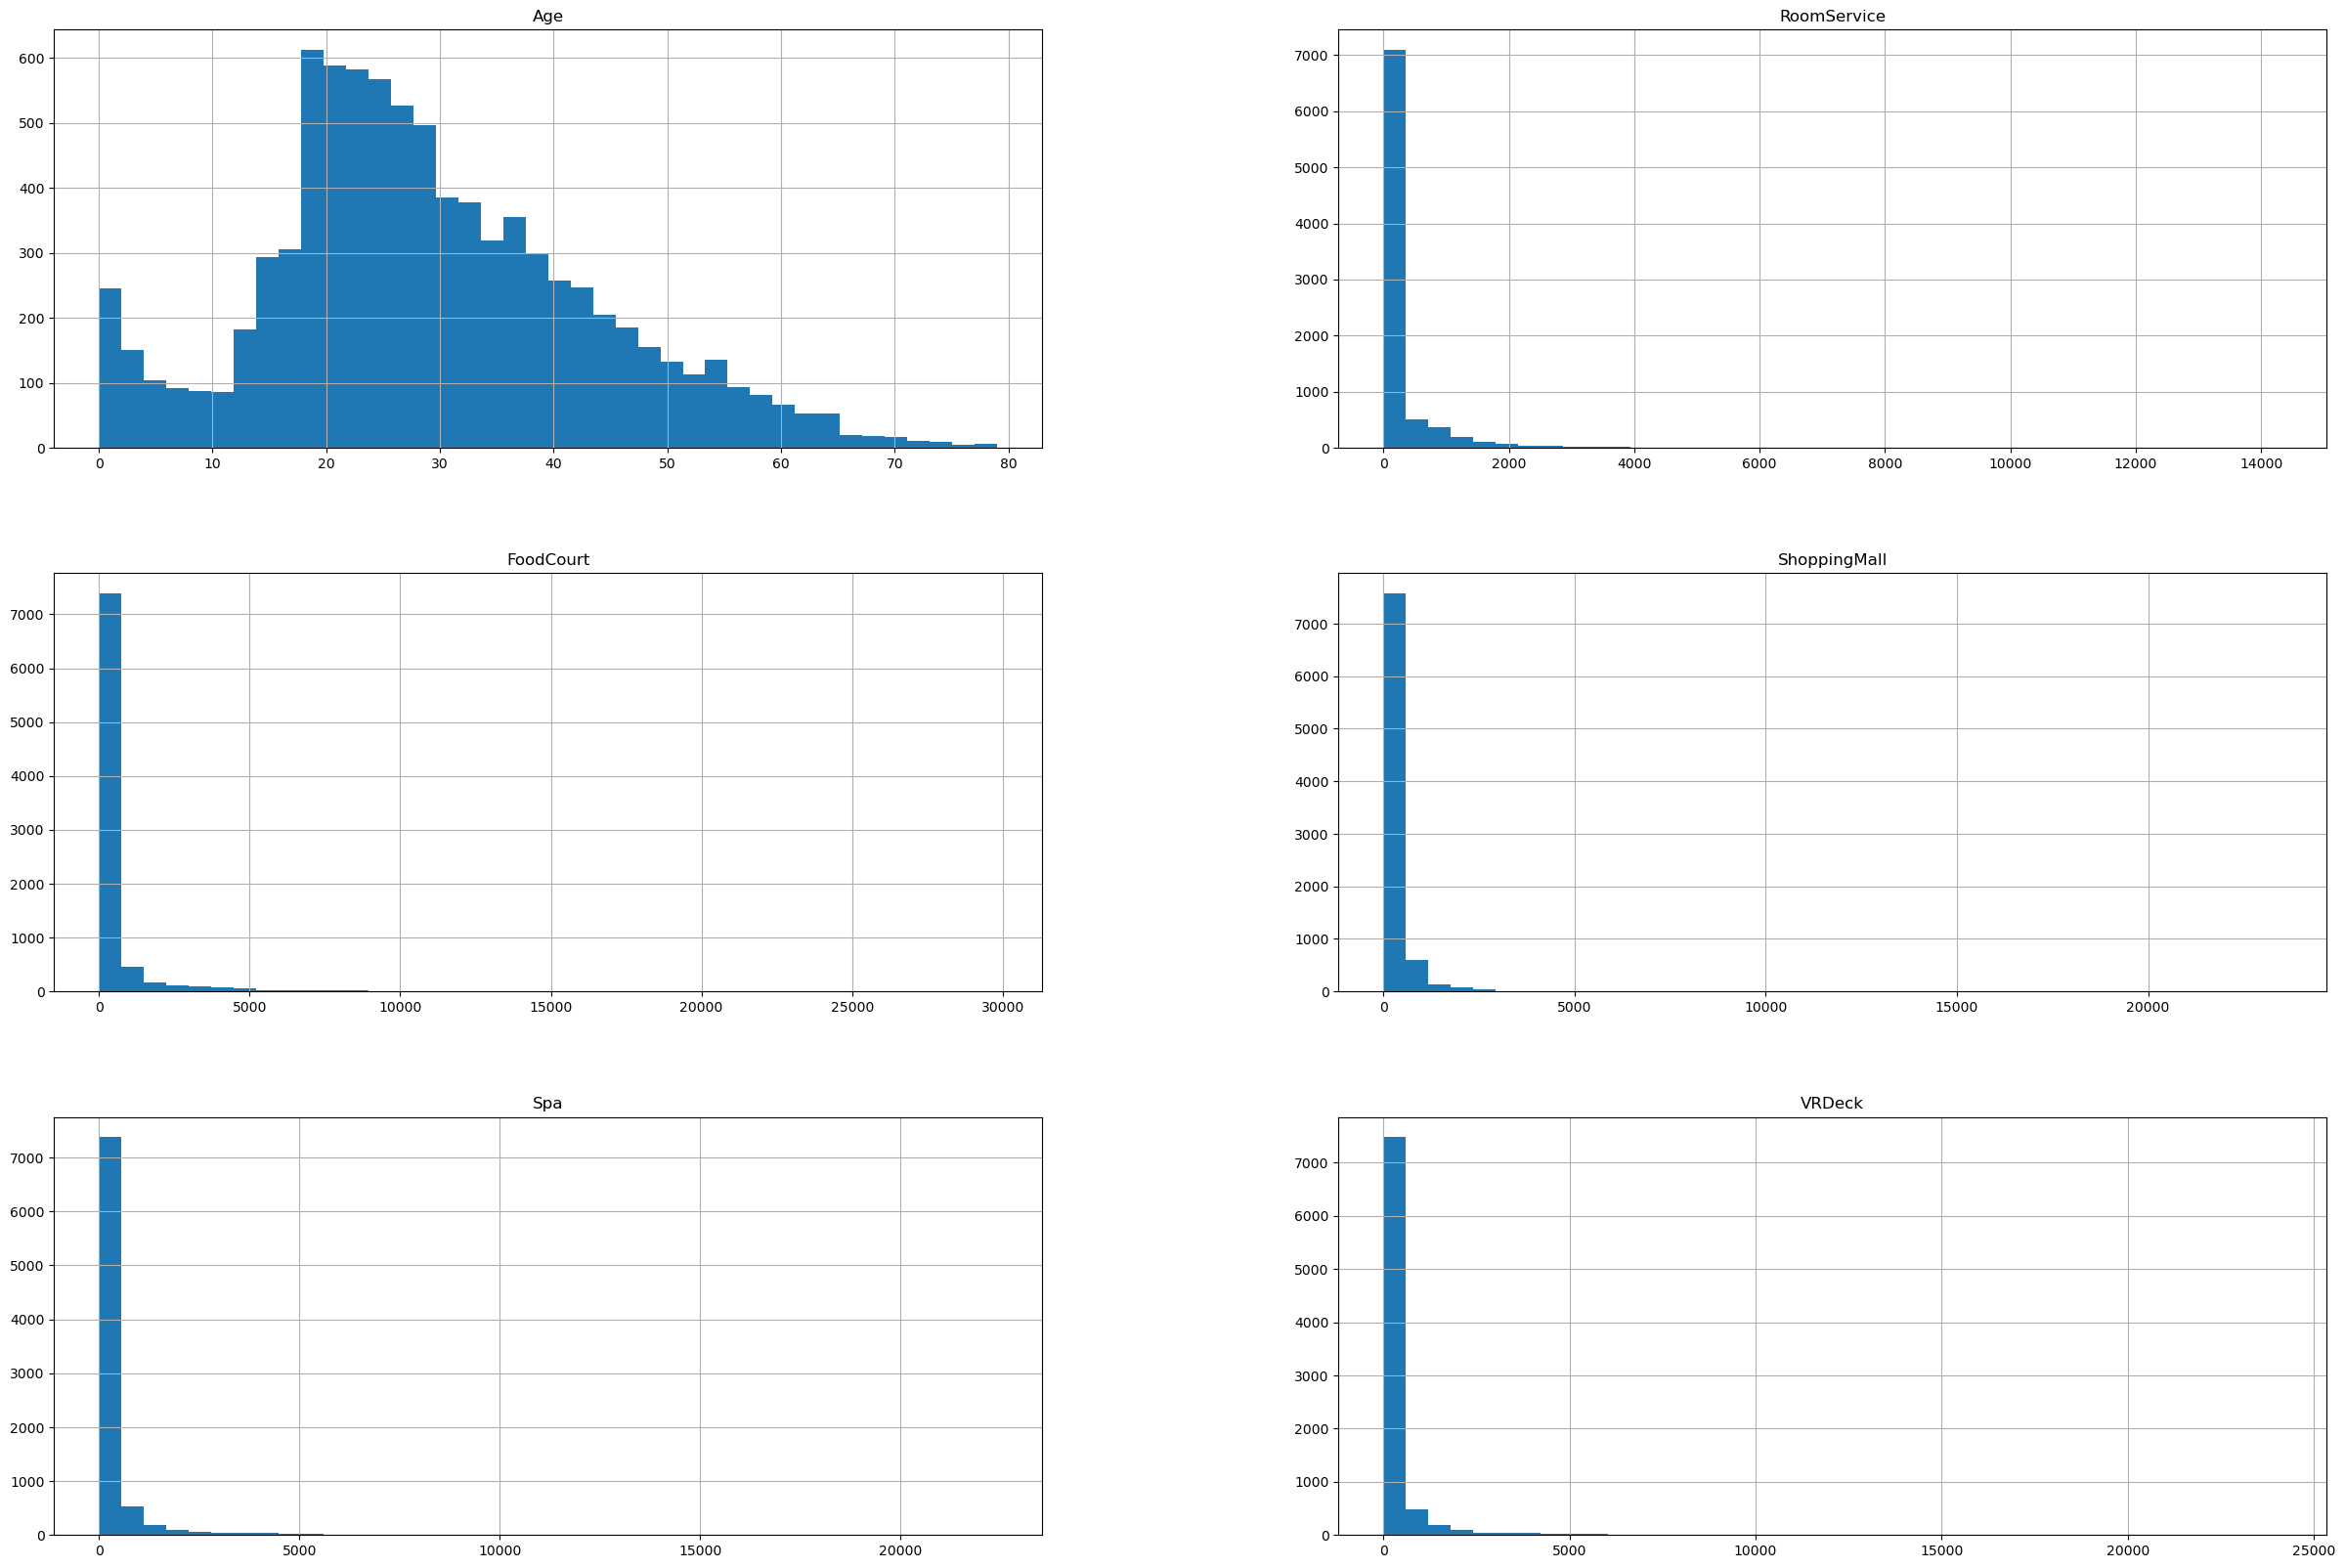

In [25]:
df_train.hist(figsize=(30, 20), bins=40)

#### How each features are correlated with target?

In [26]:
df_train_numerc_only = df_train._get_numeric_data()
corr_matrix = df_train_numerc_only.corr()
corr_matrix['Transported'].sort_values(ascending=False)

Transported     1.000000
FoodCourt       0.046566
ShoppingMall    0.010141
Age            -0.075026
VRDeck         -0.207075
Spa            -0.221131
RoomService    -0.244611
Name: Transported, dtype: float64

#### test data

In [27]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


## DATA PREPROCESSING

In [28]:
df_test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


#### Concatenating train and test dataframes - to do all preprocessing operations at once

In [29]:
train_ids = df_train['PassengerId']
test_ids = df_test['PassengerId']

df = pd.concat([df_train.drop(columns=['Transported']), df_test], axis=0, ignore_index=True)

#### Filling null values and dropping 'Name' column

In [30]:
df['HomePlanet'].fillna('Nan', inplace=True)
df['Cabin'].fillna('Nan', inplace=True)
df['Destination'].fillna('Nan', inplace=True)

columns_to_impute = ['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

imputer = IterativeImputer(
    estimator=KNeighborsClassifier(),
    max_iter=10,
    random_state=12
)
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

df.drop(columns=['Name'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12970 non-null  object 
 2   CryoSleep     12970 non-null  float64
 3   Cabin         12970 non-null  object 
 4   Destination   12970 non-null  object 
 5   Age           12970 non-null  float64
 6   VIP           12970 non-null  float64
 7   RoomService   12970 non-null  float64
 8   FoodCourt     12970 non-null  float64
 9   ShoppingMall  12970 non-null  float64
 10  Spa           12970 non-null  float64
 11  VRDeck        12970 non-null  float64
dtypes: float64(8), object(4)
memory usage: 1.2+ MB


#### Some feature engineering

In [31]:
luxury_amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
shopping_features = ['FoodCourt', 'ShoppingMall']
service_features = ['RoomService', 'Spa', 'VRDeck']

df['Total_Spending'] = df[luxury_amenities].sum(axis=1)
df['No_spending'] = (df['Total_Spending']==0).astype(int)
df['UsedAmenities'] = df[luxury_amenities].gt(0).sum(axis=1)
df['Service_Spending'] = df[service_features].sum(axis=1)
df['Shopping_Spending'] = df[shopping_features].sum(axis=1)

df[["Deck", "Cabin_num", "Side"]] = df["Cabin"].str.split("/", expand=True)
df.drop(columns=['Cabin'], inplace=True)

#### Converting boolean columns to integer

In [32]:
df['VIP'] = df['VIP'].astype(int)
df['CryoSleep'] = df['CryoSleep'].astype(int)

#### One hot encoding on non-numerical columns

In [33]:
df_encoded = pd.get_dummies(df, columns=['HomePlanet', "Deck", "Cabin_num", "Side", 'Destination'])
df_encoded

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Total_Spending,...,Cabin_num_996,Cabin_num_997,Cabin_num_998,Cabin_num_999,Side_P,Side_S,Destination_55 Cancri e,Destination_Nan,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0001_01,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,1
1,0002_01,0,24.0,0,109.0,9.0,25.0,549.0,44.0,736.0,...,0,0,0,0,0,1,0,0,0,1
2,0003_01,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,10383.0,...,0,0,0,0,0,1,0,0,0,1
3,0003_02,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,5176.0,...,0,0,0,0,0,1,0,0,0,1
4,0004_01,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1091.0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,1,34.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,1
12966,9269_01,0,42.0,0,0.0,847.0,17.0,10.0,144.0,1018.0,...,0,0,0,0,0,0,0,0,0,1
12967,9271_01,1,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,0,0,0
12968,9273_01,0,29.0,0,0.0,2680.0,0.0,0.0,523.0,3203.0,...,0,0,0,0,1,0,0,1,0,0


#### Scaling numerical columns

In [34]:
df_scaled = df_encoded
scaler = StandardScaler()
columns_to_scale = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df_scaled[columns_to_scale] = scaler.fit_transform(df_scaled[columns_to_scale])
df_scaled.set_index('PassengerId', inplace=True)

#### Reducing dimensionality using Principal Component Analysis

In [35]:
pca = PCA(n_components=100)
df_pca = pd.DataFrame(pca.fit_transform(df_scaled), index=df_scaled.index)

#### Splitting dataframe to train and test sets

In [36]:
test = df_pca.tail(df_test.shape[0])

X = df_pca.head(df_train.shape[0])
y = df_train['Transported'].astype(int)

#### 'Cutting off' validation set from train set

In [37]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## BUILDING AND TRAINING NN

#### Building and compiling keras model

In [38]:
model = keras.models.Sequential([
    
    keras.layers.Dense(512, input_dim=100),
    keras.layers.BatchNormalization(),        # Normalizing layer inputs to improve training speed and convergence.
    keras.layers.LeakyReLU(alpha=0.2),       # Leaky relu to avoid 'dying ReLU problem' 
    keras.layers.Dropout(0.3),             # Dropout for regularization
    
    keras.layers.Dense(256),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(128),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dropout(0.3),

    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 1024)              103424    
                                                                 
 batch_normalization_4 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_5 (Batc  (None, 512)              2048      
 hNormalization)                                      

#### Callbacks: 
##### early stopping - stops training after model starts to overfitting, 
##### learning rate scheduler - adjusts the learning rate during training to improve convergence and accuracy

In [39]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [40]:
def learning_rate_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
lr_scheduler = LearningRateScheduler(learning_rate_scheduler)

#### Training

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

#### Learning curves

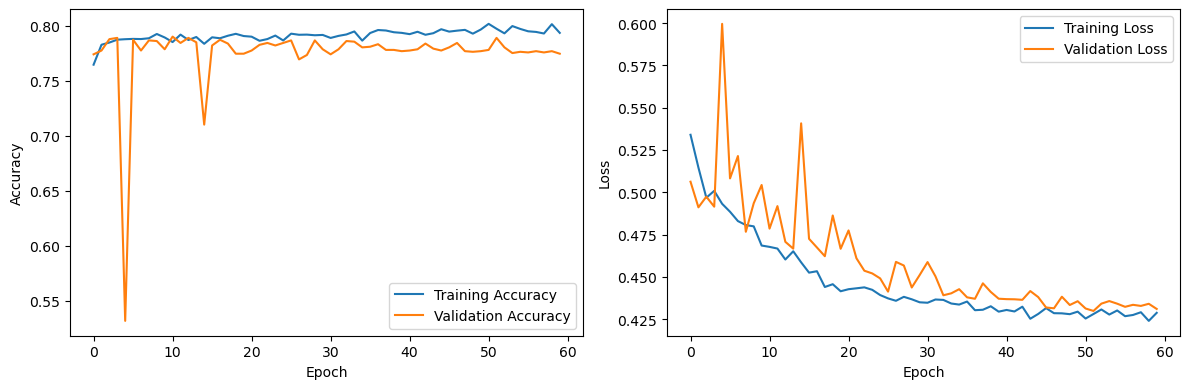

In [42]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#### Predictions

In [43]:
predictions = pd.DataFrame({
    'Transported': [True if i > 0.5 else False for i in model.predict(test)],
    'PassengerId': test.index
}).set_index('PassengerId')
predictions.to_csv('predictions.csv')

134/134 [==============================] - 1s 4ms/step
